In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Literal
from collections import defaultdict

sns.set_context("notebook")
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
FDF_GRAIN_SIZE: Literal["url", "context", "program"] = "url"

In [3]:
OUT_PATH = Path('output')
IN_PATH = Path('input')

In [4]:
# df_raw = pd.read_pickle(IN_PATH / 'df-all-merged-1.pkl.zstd', compression='zstd')
df_raw = pd.read_pickle(IN_PATH / 'clean-df_huls_label-0403.pkl.zstd', compression='zstd')
df_huls = df_raw[df_raw.gl_info.apply(lambda x: x['whenUsedWebgl'] is not None if x is not None else False)].copy()
# # `hundred_frames_status` start with skip
# # `hundred_frames_status` is "N/A"
# # `gl_info` is None
# supplement_url = sorted(set(pd.concat([
#     df_huls[df_huls['hundred_frames_status'].str.startswith('skip')],
#     # df_huls[df_huls['hundred_frames_status'] == 'N/A'],
#     # df_huls[df_huls['gl_info'].isnull()]
# ]).url))
# with open("tmp_supplement_url.txt", "w") as f:
#     f.write("\n".join(supplement_url))
# supplement_url
# def used_webgl(x):
#     return x is not None and x['whenUsedWebgl'] is not None
# def render_time(x):
#     if x is None or x['whenUsedWebgl'] is None or x['when'] is None:
#         return -1
#     return x['when'] - x['whenUsedWebgl']

# ok_df = df_huls[df_huls['gl_info'].map(used_webgl)]
# with open('ok_urls.txt', 'w') as f:
#     f.write("\n".join(ok_df.url))
# not_ok_df = df_huls[~df_huls['gl_info'].map(used_webgl)]
# with open('not_ok_urls.txt', 'w') as f:
#     f.write("\n".join(not_ok_df.url))
# err_df = df_huls[df_huls['gl_info'].isnull()]
# with open('err_urls.txt', 'w') as f:
#     f.write("\n".join(err_df.url))
# fast_df = df_huls[df_huls['gl_info'].map(render_time) < 10000]
# with open('fast_urls.txt', 'w') as f:
#     f.write("\n".join(fast_df.url))
df_huls.webgl_status.value_counts()

Ok                  5449
TimeoutException       2
Name: webgl_status, dtype: Int64

In [5]:
df_raw.url.is_unique

True

In [6]:
gl_infos = df_huls['gl_info'].dropna().tolist()
print(len(gl_infos))

5451


In [7]:
with open(OUT_PATH / 'example' / 'gl_info.json', 'w') as fp:
    json.dump(gl_infos[0], fp, indent=2)

In [8]:
def get_canvas_length(gl_info):
    if gl_info is None:
        return 0
    return len(gl_info['contextInfo'])

In [9]:
df_huls['canvas_length'] = df_huls['gl_info'].map(get_canvas_length)

Figure out why a webpage contains more than one canvas. List some urls and their canvas counts.

In [10]:
df_huls[df_huls['canvas_length'] > 1][['url', 'canvas_length', 'gl_info']]

,url,canvas_length,gl_info
11,http://1j1d.art,4,"{'accessTime': 1679326485110, 'contextInfo': [..."
14,http://2016.makemepulse.com,5,"{'accessTime': 1679326466786, 'contextInfo': [..."
20,http://20years.polymetalinternational.com/,2,"{'accessTime': 1679326603607, 'contextInfo': [..."
27,http://3d.halestormproductions.com/,2,"{'accessTime': 1679326632395, 'contextInfo': [..."
34,http://80.253.29.55:3001/Typ.html,4,"{'accessTime': 1679326705594, 'contextInfo': [..."
...,...,...,...
8359,https://zap.ramotion.agency,7,"{'accessTime': 1679417767017, 'contextInfo': [..."
8375,https://zestore.fr/,2,"{'accessTime': 1679417923090, 'contextInfo': [..."
8390,https://zoccon.me/,2,"{'accessTime': 1679414129739, 'contextInfo': [..."
8391,https://zoccon.me/https://tagree.agency/,2,"{'accessTime': 1679418080308, 'contextInfo': [..."


# In other words, could we detect the pattern of an empty canvas?

In [11]:
tmp = df_raw[df_raw['url'] == 'http://sonorannews.com'].gl_info.iloc[0]
open(OUT_PATH / 'example' / 'tmp.json', 'w').write(json.dumps(tmp, indent=2))

21044

# canvas sizes

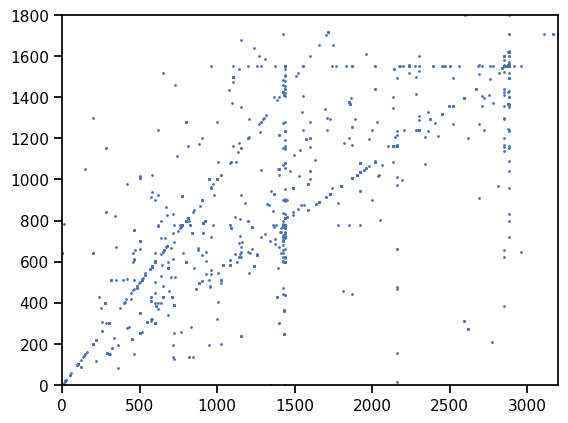

59

In [12]:
canvas_sizes = [y['canvasSize'] for x in gl_infos for y in x['contextInfo']]
# plot the distribution of canvas size( as scatter plot)
plt.scatter([x[0] for x in canvas_sizes], [x[1] for x in canvas_sizes], s=1)
plt.xlim(0, 3200)
plt.ylim(0, 1800)
plt.show()
# count the canvas which size is larger than 3200x1800
len([x for x in canvas_sizes if x[0] > 3200 or x[1] > 1800])

In [13]:
import re
def remove_whitespaces(s: str):
    return re.sub(r'\s+', '', s)

In [14]:
remove_whitespaces("t est\nHelloworl d")

'testHelloworld'

In [15]:
def extract_shaders(ctx_info, context_id=-1):
    ret = ([], []) # vert, frag
    for x in ctx_info['programInfo']:
        if x is None: continue
        for y in x['vertexShaders']:
            if type(y) != str:
                # print(ctx_info)
                pass
            else:
                ret[0].append([remove_whitespaces(y), y, ctx_info['url'], context_id])
        for y in x['fragmentShaders']:
            if type(y) != str:
                # print(ctx_info)
                pass
            else:
                ret[1].append([remove_whitespaces(y), y, ctx_info['url'], context_id])
    return ret

In [16]:
def flatten_ctx_info(ctx_info):
    ret = {}
    
    ret['url'] = ctx_info['url']
    ret['when'] = ctx_info['when']
    ret['accessTime'] = ctx_info['accessTime']
    ret['whenDomContentLoadedEvent'] = ctx_info['whenDomContentLoadedEvent']
    ret['whenLoadEvent'] = ctx_info['whenLoadEvent']
    ret['whenUsedWebgl'] = ctx_info['whenUsedWebgl']
    ret['contextType'] = ctx_info['maghsk']['createArguments'][0]
    if len(ctx_info['maghsk']['createArguments']) == 2:
        # print(ctx_info['maghsk']['createArguments'])
        if ctx_info['maghsk']['createArguments'][1] is not None:
            for k, v in ctx_info['maghsk']['createArguments'][1].items():
                ret['arg_{}'.format(k)] = v
    elif len(ctx_info['maghsk']['createArguments']) > 2:
        # print("ERROR", ctx_info['maghsk']['createArguments'])
        raise ValueError("ERROR", ctx_info['maghsk']['createArguments'])

    ret['rafCalled_total'] = ctx_info['rafCalled_total']
    ret['rafCalled_max'] = ctx_info['rafCalled_max']
    ret['vertexCount'] = ctx_info['vertexCount']
    ret['triangleCount'] = ctx_info['triangleCount']
    ret['extensions'] = sorted(x for x in set(ctx_info['extensions']) if x != 'GMAN_webgl_memory')
    
    # ret['canvas_hidden'] = ctx_info['canvasHidden']
    # ret['offscreen'] = ctx_info['maghsk']['isOffScreen']
    ret['program_use'] = 0 
    ret['program_count'] = 0
    for x in ctx_info['programInfo']:
        if x is None: continue
        ret['program_use'] += x['useCounts']
        ret['program_count'] += 1
    vert, frag = extract_shaders(ctx_info)
    ret['shader_length'] = sum(len(x[0]) for x in vert) + sum(len(x[0]) for x in frag)
    ret['shader_count'] = len(vert) + len(frag)

    mem_info = ctx_info['memoryInfo']
    memory = mem_info['memory']
    resources = mem_info['resources']
    for key, value in sorted(memory.items()):
        # if key == 'total':
        ret['_memory_' + key] = value
    for key, value in sorted(resources.items()):
        ret['_resources_' + key] = value
    
    func_count = ctx_info['maghsk']['funcCount']
    ret['total_func_call'] = 0
    ret['total_memory'] = memory['total']
    for key, value in sorted(func_count.items()):
        ret['_func_call_' + key] = value
        ret['total_func_call'] += value

    return ret

# Flatten ContextInfos

In [17]:
context_infos = []
for gl_info in gl_infos:
    for y in gl_info['contextInfo']:
        y['url'] = gl_info['url']
        y['when'] = gl_info['when']
        y['accessTime'] = gl_info['accessTime']
        y['whenDomContentLoadedEvent'] = gl_info['whenDomContentLoadedEvent']
        y['whenLoadEvent'] = gl_info['whenLoadEvent']
        y['whenUsedWebgl'] = gl_info['whenUsedWebgl']
        try:
            y['rafCalled_total'] = sum(gl_info['rafFuncCountList'])
            y['rafCalled_max'] = max(gl_info['rafFuncCountList'], default=0)
        except:
            print(gl_info['rafFuncCountList'])
            print(gl_info['url'])
            print(gl_info['whenUsedWebgl'])
            continue
        context_infos.append(y)
context_infos = sorted(context_infos, key=lambda x: sum(y for y in x['maghsk']['funcCount'].values()), reverse=True)

[[None]]
https://custom.gomezsimindustries.com/
898.2000000029802


In [18]:
# fcontext_infos = [flatten_ctx_info(x) for x in context_infos]
fcontext_infos = []
fdf_columns = set()
for x in context_infos:
    fcontext_infos.append(flatten_ctx_info(x))
    fdf_columns.update(flatten_ctx_info(x).keys())

fdf = pd.DataFrame(fcontext_infos)
# zip column name with dtype
for x in fdf.columns.tolist():
    print(x, fdf[x].dtype)

url object
when float64
accessTime int64
whenDomContentLoadedEvent float64
whenLoadEvent float64
whenUsedWebgl float64
contextType object
arg_alpha object
arg_antialias object
arg_depth object
arg_premultipliedAlpha object
arg_preserveDrawingBuffer object
arg_stencil object
rafCalled_total int64
rafCalled_max int64
vertexCount float64
triangleCount float64
extensions object
program_use int64
program_count int64
shader_length int64
shader_count int64
_memory_buffer int64
_memory_drawingbuffer int64
_memory_renderbuffer float64
_memory_texture float64
_memory_total float64
_resources_buffer int64
_resources_framebuffer int64
_resources_program int64
_resources_renderbuffer int64
_resources_shader int64
_resources_texture int64
total_func_call int64
total_memory float64
_func_call_activeTexture float64
_func_call_attachShader float64
_func_call_bindBuffer float64
_func_call_bindFramebuffer float64
_func_call_bindRenderbuffer float64
_func_call_bindTexture float64
_func_call_blendEquation 

In [19]:
fdf.fillna(0, inplace=True)
print((len(fdf[fdf['total_func_call'] == 0])))
fdf_url = fdf.groupby('url').aggregate(np.sum)
fdf = fdf[fdf['total_func_call'] > 0]
fdf_url[fdf_url['total_func_call'] == 0].to_csv(OUT_PATH / 'total_func_call_0.csv')
fdf_url[fdf_url['shader_count'] == 0].to_csv(OUT_PATH / 'shader_count_0.csv')
fdf_url[fdf_url['program_count'] == 1].to_csv(OUT_PATH / 'program_count_1.csv')
fdf_url[fdf_url['_memory_total'] == 0].to_csv(OUT_PATH / '_memory_total_0.csv')
fdf_url = fdf_url[fdf_url['total_func_call'] > 0]
fdf

3632


/tmp/ipykernel_10332/3127469534.py:3: FutureWarning: The operation <function sum at 0x7fe48c178af0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  fdf_url = fdf.groupby('url').aggregate(np.sum)


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
0,https://www.dangleterre.com/en/meetings-events...,47412.3,1679393271065,17586.4,17598.7,17216.7,webgl,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
1,http://127.0.0.1:8000/test1/webgl/hard,32861.5,1679326370599,695.0,695.2,231.7,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
2,http://127.0.0.1:8000/test3/webgl/medium,31640.2,1679326403021,1228.5,1228.7,1024.6,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
3,http://127.0.0.1:8000/test1/webgl/medium,31447.5,1679326372954,661.8,661.9,317.7,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
4,https://www.boranka.hr/en,37150.4,1679394560031,6724.0,14520.5,6688.8,webgl,False,False,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
4871,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
4872,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
4873,https://www.thoughtlab.com/,33158.6,1679410205569,3097.2,8205.9,3069.0,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


In [20]:
len(fdf.url.unique())

2645

# Context Type

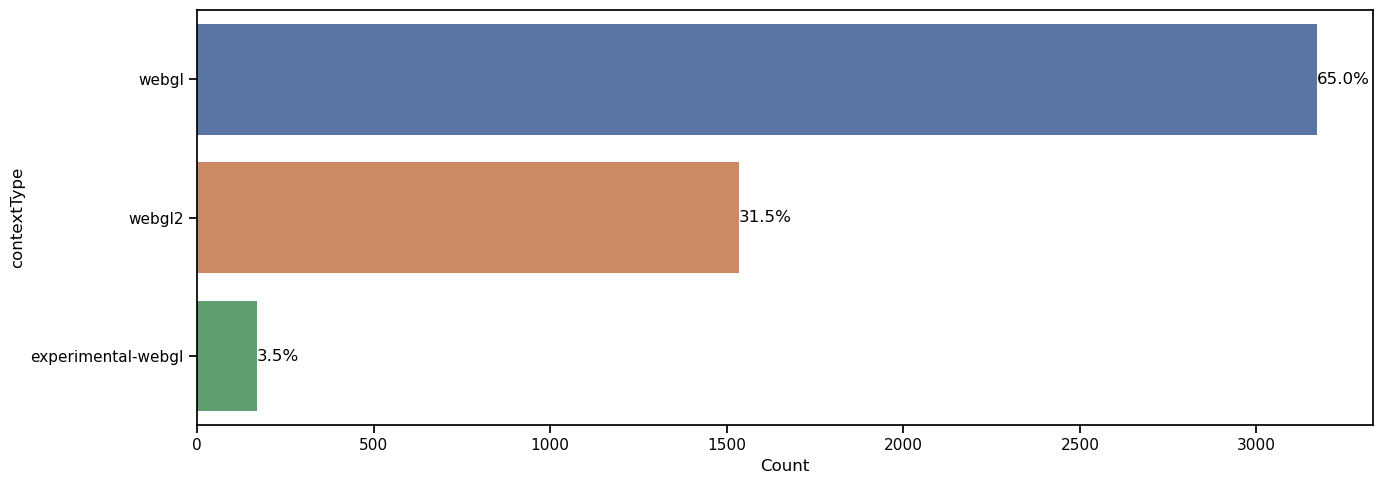

In [21]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='contextType', data=fdf, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('contextType')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Power Preference

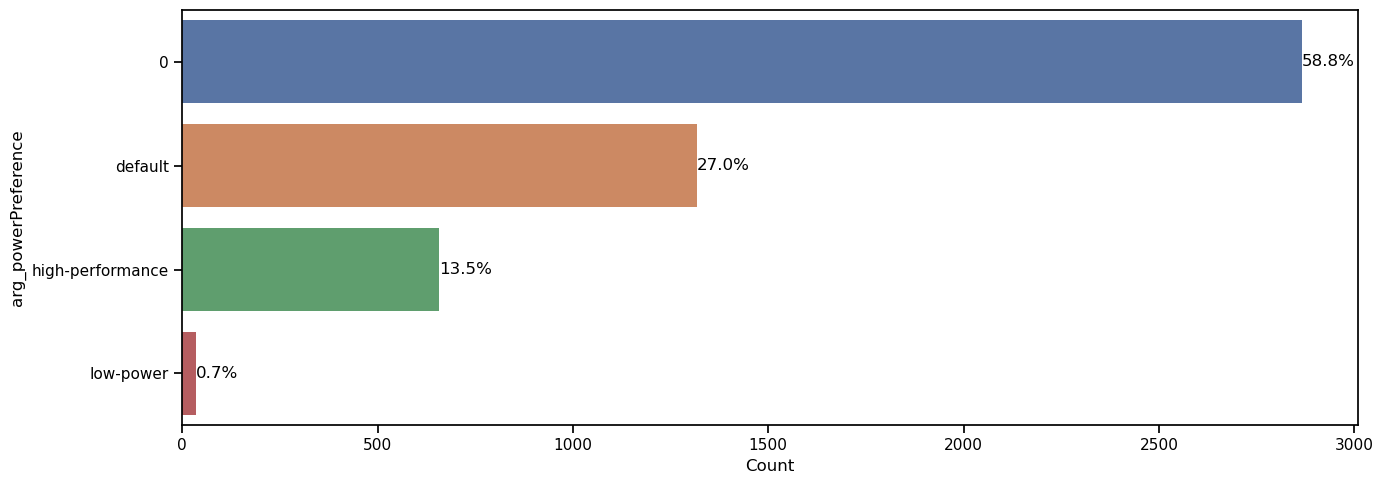

In [22]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='arg_powerPreference', data=fdf, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('arg_powerPreference')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Context Attrib

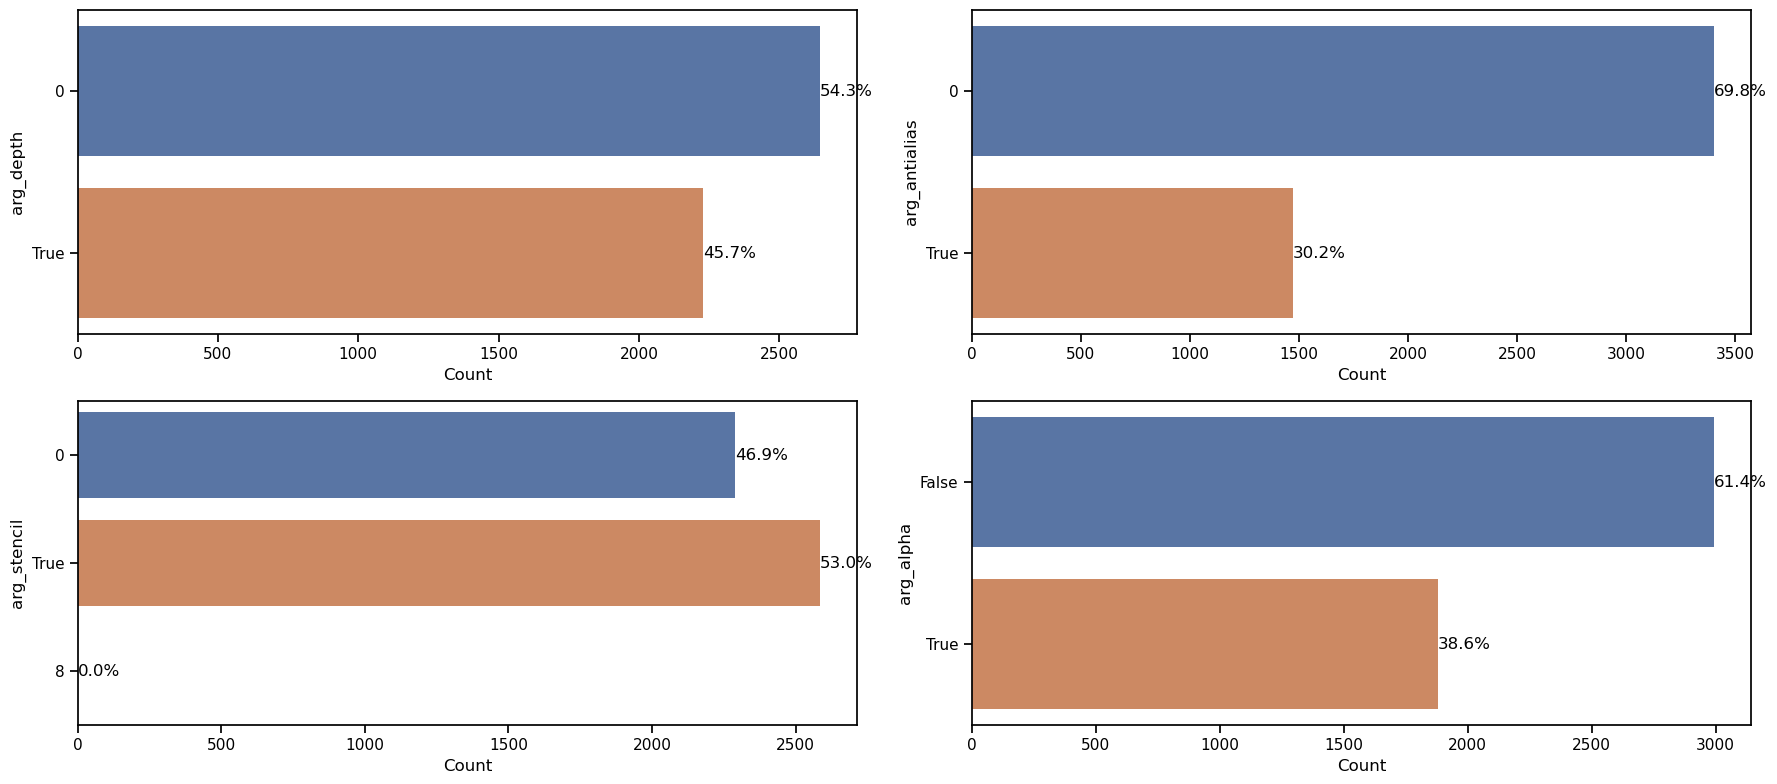

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

sns.countplot(y='arg_depth', data=fdf, ax=axes[0,0])
axes[0,0].set_xlabel('Count')
axes[0,0].set_ylabel('arg_depth')

sns.countplot(y='arg_antialias', data=fdf, ax=axes[0,1])
axes[0,1].set_xlabel('Count')
axes[0,1].set_ylabel('arg_antialias')

sns.countplot(y='arg_stencil', data=fdf, ax=axes[1,0])
axes[1,0].set_xlabel('Count')
axes[1,0].set_ylabel('arg_stencil')

sns.countplot(y='arg_alpha', data=fdf, ax=axes[1,1])
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('arg_alpha')

for x in range(2):
    for y in range(2):
        for rect in axes[x,y].patches:
            axes[x,y].annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                                (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                                ha='left', va='center')

plt.tight_layout()
plt.show()

In [24]:
(fdf.when - fdf.whenUsedWebgl).describe()

count      4875.000000
mean      31089.605914
std        5919.251235
min          56.300000
25%       30140.300000
50%       30266.100000
75%       30402.700000
max      109700.600000
dtype: float64

# Extensions

In [25]:
tmp = fdf.extensions.apply(len)
print("percentage of context which has no extension: {:.2f}%".format((tmp == 0).sum() / len(tmp) * 100))

percentage of context which has no extension: 10.05%


In [26]:
with open('input/webgl-extension-categories.json', 'r') as fp:
    category_to_extension = json.load(fp)

extension_to_category = defaultdict(lambda: 'unknown')
for category, extensions in category_to_extension.items():
    for extension in extensions:
        extension_to_category[extension] = category

In [27]:
extension_to_category['233']

'unknown'

count                          4385
unique                          238
top       WEBGL_debug_renderer_info
freq                           1043
Name: extensions, dtype: object


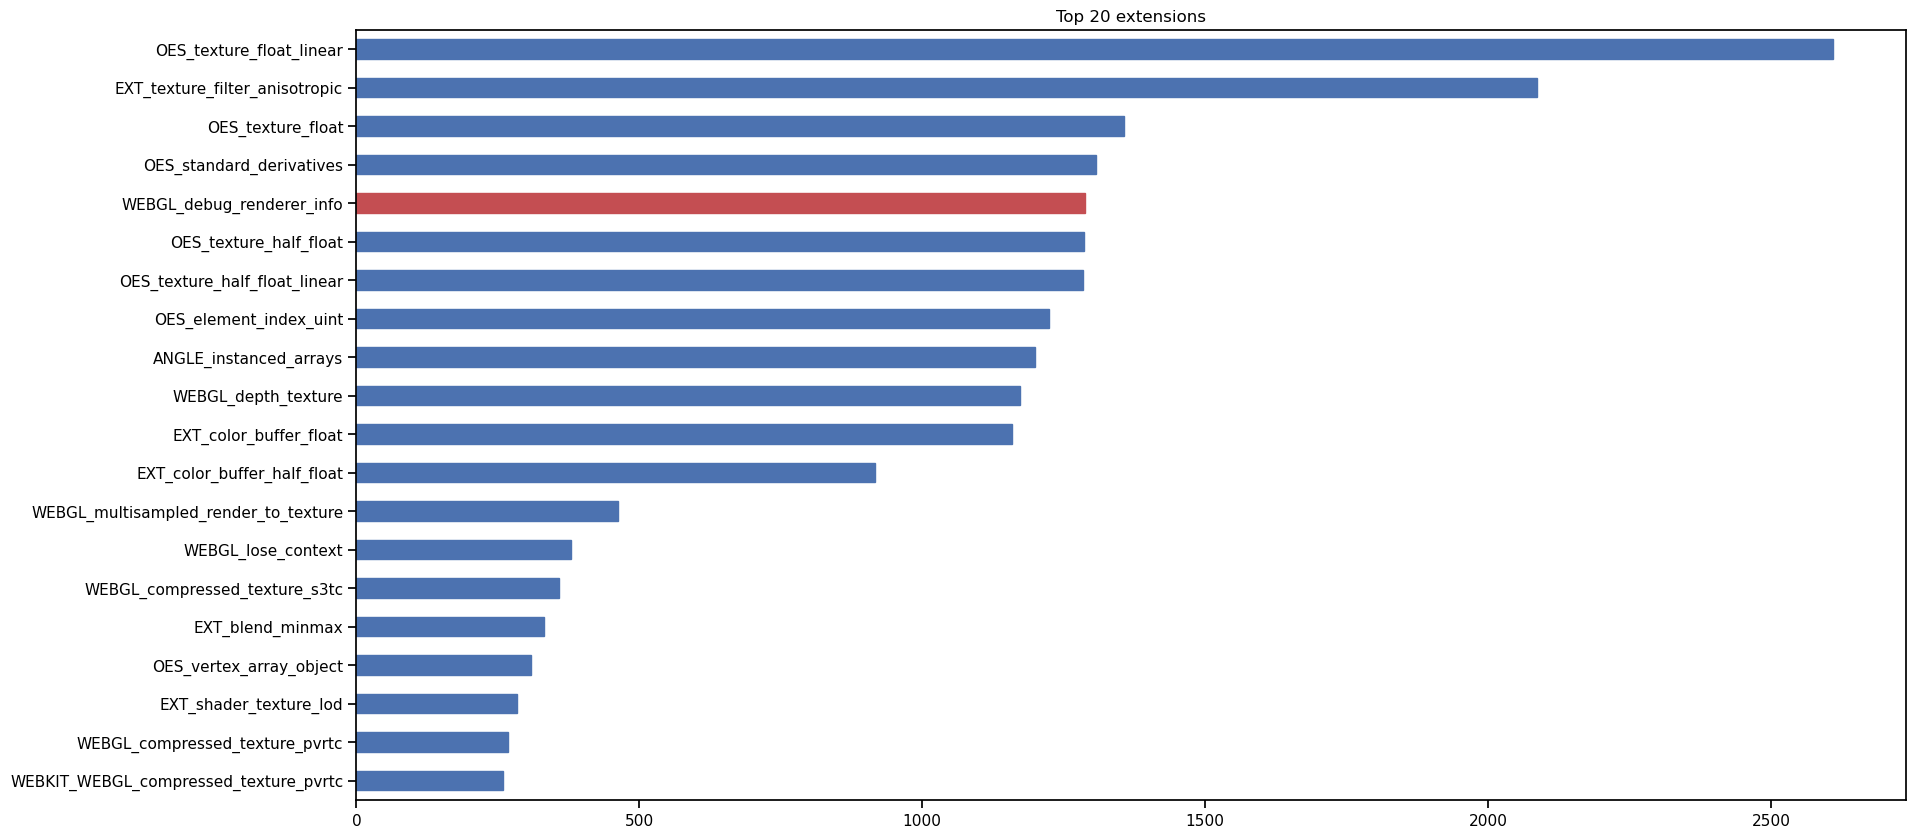

In [28]:
extension = fdf[fdf.extensions.apply(len) > 0].extensions
tmp = extension.apply(lambda x: ';'.join(x)).value_counts().to_dict()
json.dump(tmp, open(OUT_PATH / 'example' / 'extension-count.json', 'w'), indent=2)
tmp2 = extension.apply(lambda x: ';'.join(x)).describe()
print(tmp2)
words_list = tmp2['top'].split(';')
tmp2 = []
for lst in extension:
    tmp2.extend(lst)

extension_df = pd.DataFrame({
    'name': pd.Series(tmp2),
    'category': pd.Series([extension_to_category[x] for x in tmp2]),
    'prefix': pd.Series([x.split('_')[0] for x in tmp2])
})
extension_df = extension_df[(extension_df['prefix'].str.len() > 2) & (extension_df['prefix'].str.upper() == extension_df['prefix'])]

tmp = extension_df['name'].value_counts(ascending=True)
# print(tmp.to_dict())
to_plot = tmp.iloc[len(tmp)-20:]
bar = to_plot.plot.barh(figsize=(20, 10))
for i, v in enumerate(to_plot.index):
    if v in words_list:
        bar.get_children()[i].set_color(sns.color_palette()[3])
    else:
        bar.get_children()[i].set_color(sns.color_palette()[0])
plt.title('Top 20 extensions')
plt.show()

In [29]:
sorted(set(extension_df[extension_df['category'] == 'unknown'].name))

['EXT_color_buffer_float_linear',
 'EXT_draw_buffers',
 'EXT_multisampled_render_to_texture',
 'MOZ_EXT_texture_filter_anisotropic',
 'MOZ_OES_texture_half_float_linear',
 'MOZ_OES_vertex_array_object',
 'MOZ_WEBGL_compressed_texture_astc',
 'MOZ_WEBGL_compressed_texture_atc',
 'MOZ_WEBGL_compressed_texture_etc',
 'MOZ_WEBGL_compressed_texture_etc1',
 'MOZ_WEBGL_compressed_texture_pvrtc',
 'MOZ_WEBGL_depth_texture',
 'OCULUS_multiview',
 'OES_float_linear',
 'OES_seamless_cube_map',
 'WEBGL_compressed_texture_es3',
 'WEBGL_compressed_texture_es3_0',
 'WEBGL_multisampled_render_to_texture',
 'WEBKIT_EXT_texture_compression_bptc',
 'WEBKIT_EXT_texture_filter_anisotropic',
 'WEBKIT_OES_texture_half_float_linear',
 'WEBKIT_OES_vertex_array_object',
 'WEBKIT_WEBGL_compressed_texture_astc',
 'WEBKIT_WEBGL_compressed_texture_atc',
 'WEBKIT_WEBGL_compressed_texture_etc',
 'WEBKIT_WEBGL_compressed_texture_etc1',
 'WEBKIT_WEBGL_compressed_texture_pvrtc',
 'WEBKIT_WEBGL_compressed_texture_s3tc',


In [30]:
extension_df['category'].value_counts()

Khronos ratified WebGL Extensions      16979
Community approved WebGL Extensions     3691
unknown                                 1065
Rejected WebGL Extensions                 85
Draft WebGL Extensions                     4
Name: category, dtype: int64

## Extension 开发过程

Extension 在其发展过程中经历了四个阶段：建议、草案、社区批准和Khronos批准。每个 extension 都应该推进到Khronos的批准。如果一个 extension 不能通过 extension 过程来推进，它可以被拒绝。

- Proposed extensions 是为了在公共WebGL邮件列表中进行讨论，以便进入草案状态；它们不应该被实现，即使是在供应商的前缀下。如果在社区中达成了共识，该 extension 就可以转为草案状态。
- Draft extensions 可以在供应商的前缀下实现，或者在运行时选项后面实现，以达到实验的目的，以便在最终确定 extension 之前获得经验。草案 extension 不应默认由WebGL实现来公开。一旦在社区中达成共识，该 extension 就可以转为Community approved 状态。
- Community approved extensions 应该在没有供应商前缀的情况下实现。当一个 extension 草案转为社区认可状态时，任何现有的实现都应该立即取消对任何厂商前缀的 extension 名称的支持。一旦被厂商实现，除非该 extension 存在严重问题，如安全漏洞，否则不应取消支持。
- Khronos ratified extensions 是那些经过Khronos委员会投票通过的Community approved extension 。
- Rejected extensions（不应被实现）。扩展进入被拒绝状态是因为在提议阶段没有达成共识或在草案阶段实施过程中出现技术困难。只有在特殊情况下，社区批准的扩展才能被拒绝。Khronos认可的扩展不能被拒绝。

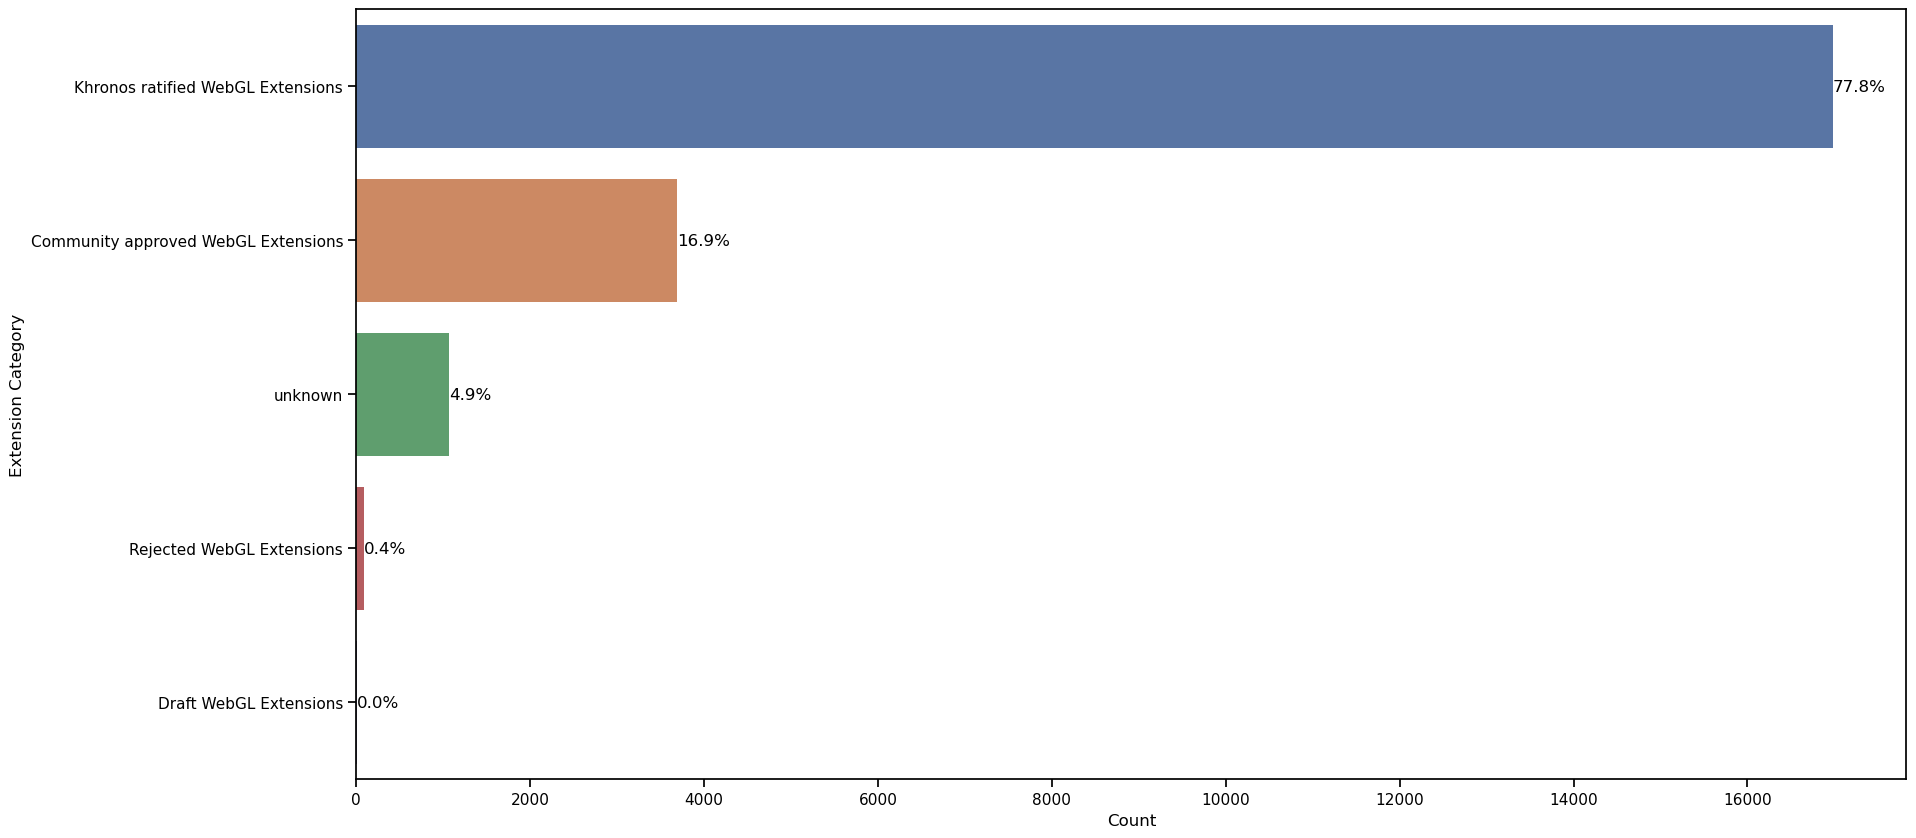

In [31]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['category'], ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Category')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.show()


## 命名约定

WebGL 扩展以“ANGLE”、“OES”、“EXT”、“WEBGL”等为前缀。这些前缀反映了来源和意图：

- `ANGLE_`: 由 ANGLE library 的作者编写的扩展。
- `OES_` 和 `KHR_`: 由各自的架构审查委员会（Khronos）批准的对 OpenGL ES（OES）或 OpenGL API 扩展的功能的镜像。
- `OVR_`: 针对虚拟现实进行优化的扩展。
- `EXT_`: 从其他 OpenGL ES 或 OpenGL API 扩展镜像的扩展。
- `WEBGL_`: 特定于 WebGL 的扩展，旨在与多种 Web 浏览器兼容。它也应该用于源自 OpenGL ES 或 OpenGL API 的扩展，但其行为已被显著改变。

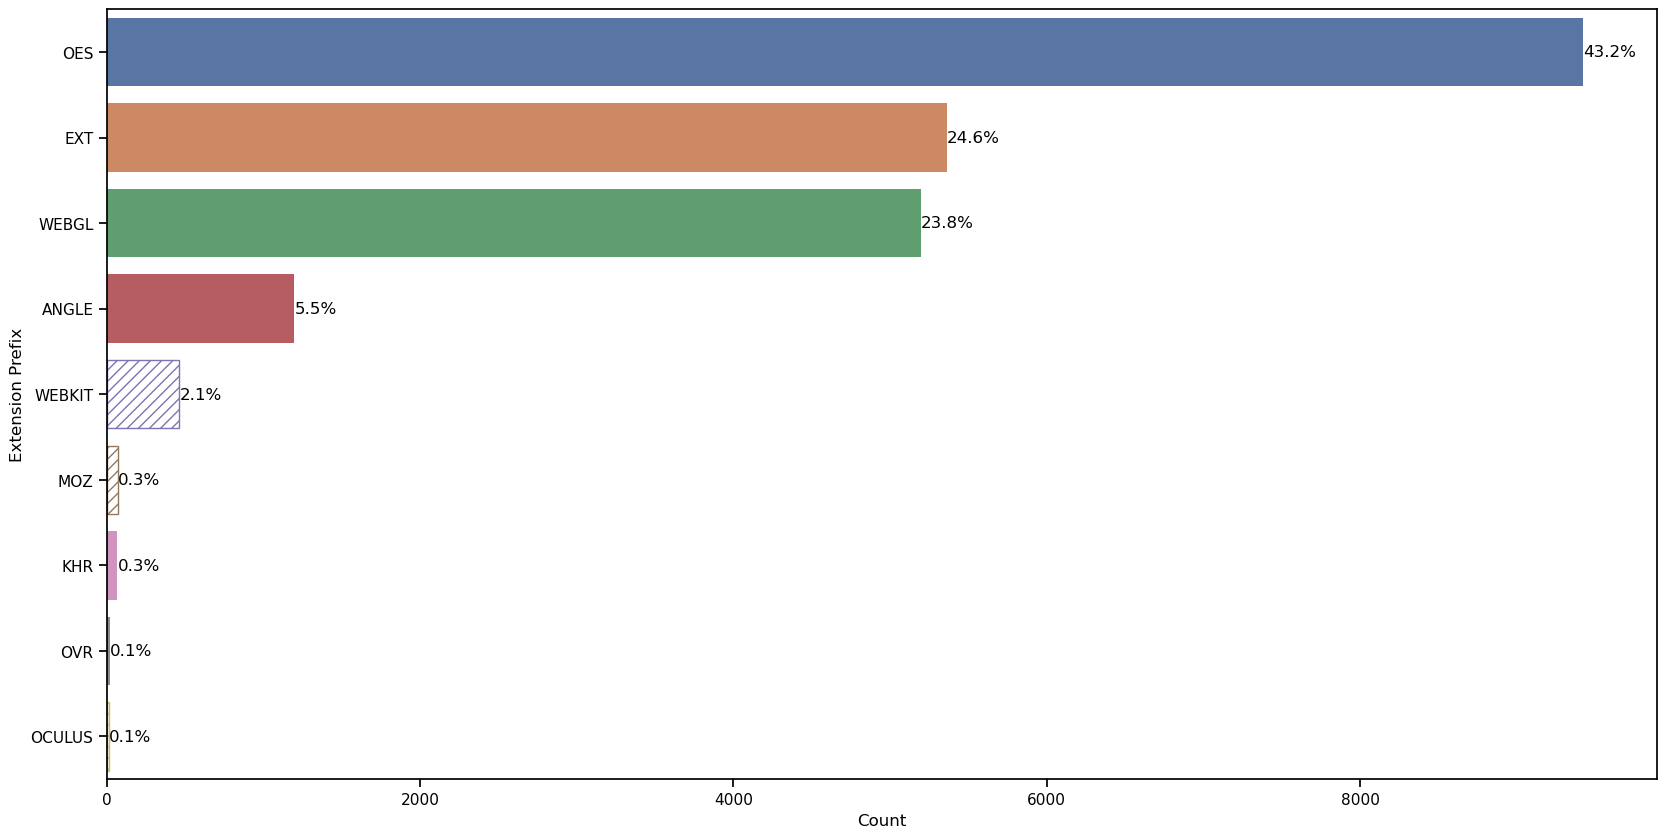

In [32]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['prefix'], ax=axes, order=extension_df['prefix'].value_counts().index)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
# hatch='///' on MOZ WEBKIT OCULUS
for i in [4,5,8]:
    axes.patches[i].set_hatch('///')
    axes.patches[i].set_facecolor('white')
    axes.patches[i].set_edgecolor(color_palette[i])
plt.show()

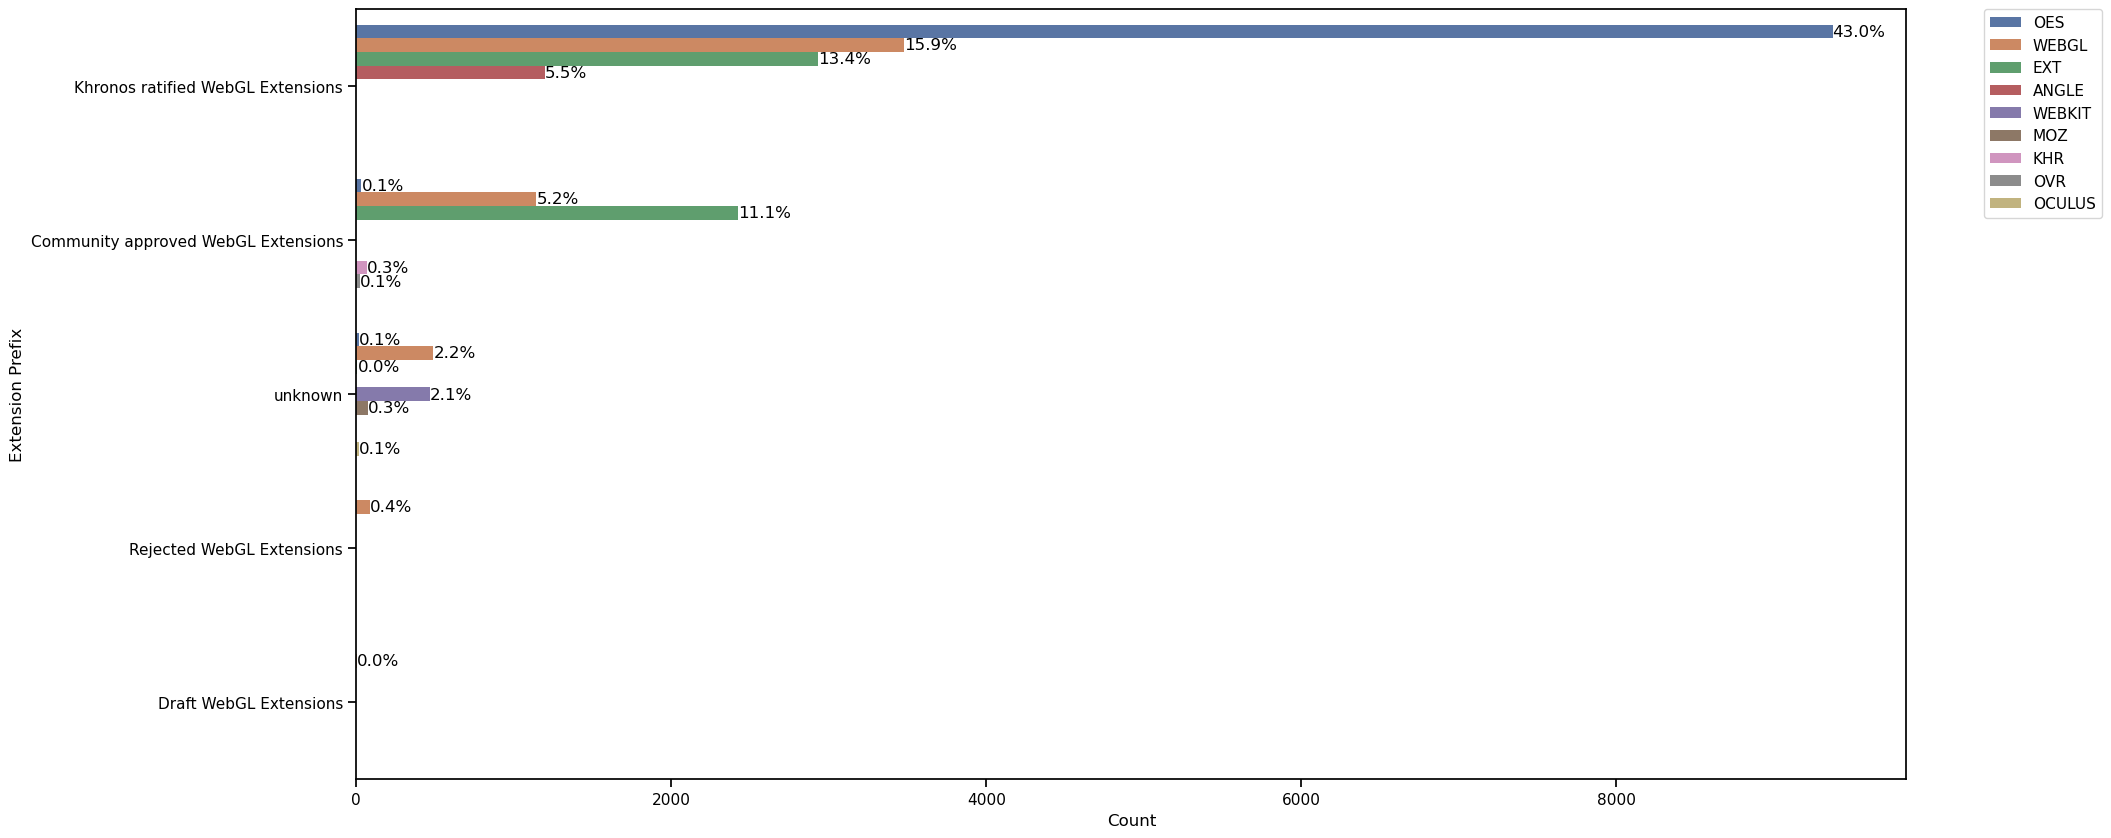

In [33]:
fig, axes = plt.subplots(figsize=(20, 10))
tmp = extension_df.value_counts(subset=['prefix', 'category'])
tmp = tmp.reset_index()
tmp.columns = ['prefix', 'category', 'count']
tmp
sns.barplot(x='count', y='category', hue='prefix', data=tmp, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [34]:
tmp = extension.apply(lambda x: ';'.join(x))
fdf[fdf.extensions.apply(len) > 0][tmp.str.contains('BdwhLT1F')]

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
3624,https://letidor.ru/age/podrostki,32775.4,1679367424727,3096.9,25632.0,2614.5,webgl,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
3625,https://letidor.ru/age/podrostki,32775.4,1679367424727,3096.9,25632.0,2614.5,webgl,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


In [35]:
extension.describe()

count                            4385
unique                            238
top       [WEBGL_debug_renderer_info]
freq                             1043
Name: extensions, dtype: object

# WebGL calls

count    4.875000e+03
mean     2.118165e+05
std      1.454178e+06
min      1.000000e+00
50%      4.460000e+02
75%      4.129400e+04
90%      3.098856e+05
95%      7.111930e+05
99%      3.493813e+06
max      4.989299e+07
Name: total_func_call, dtype: float64


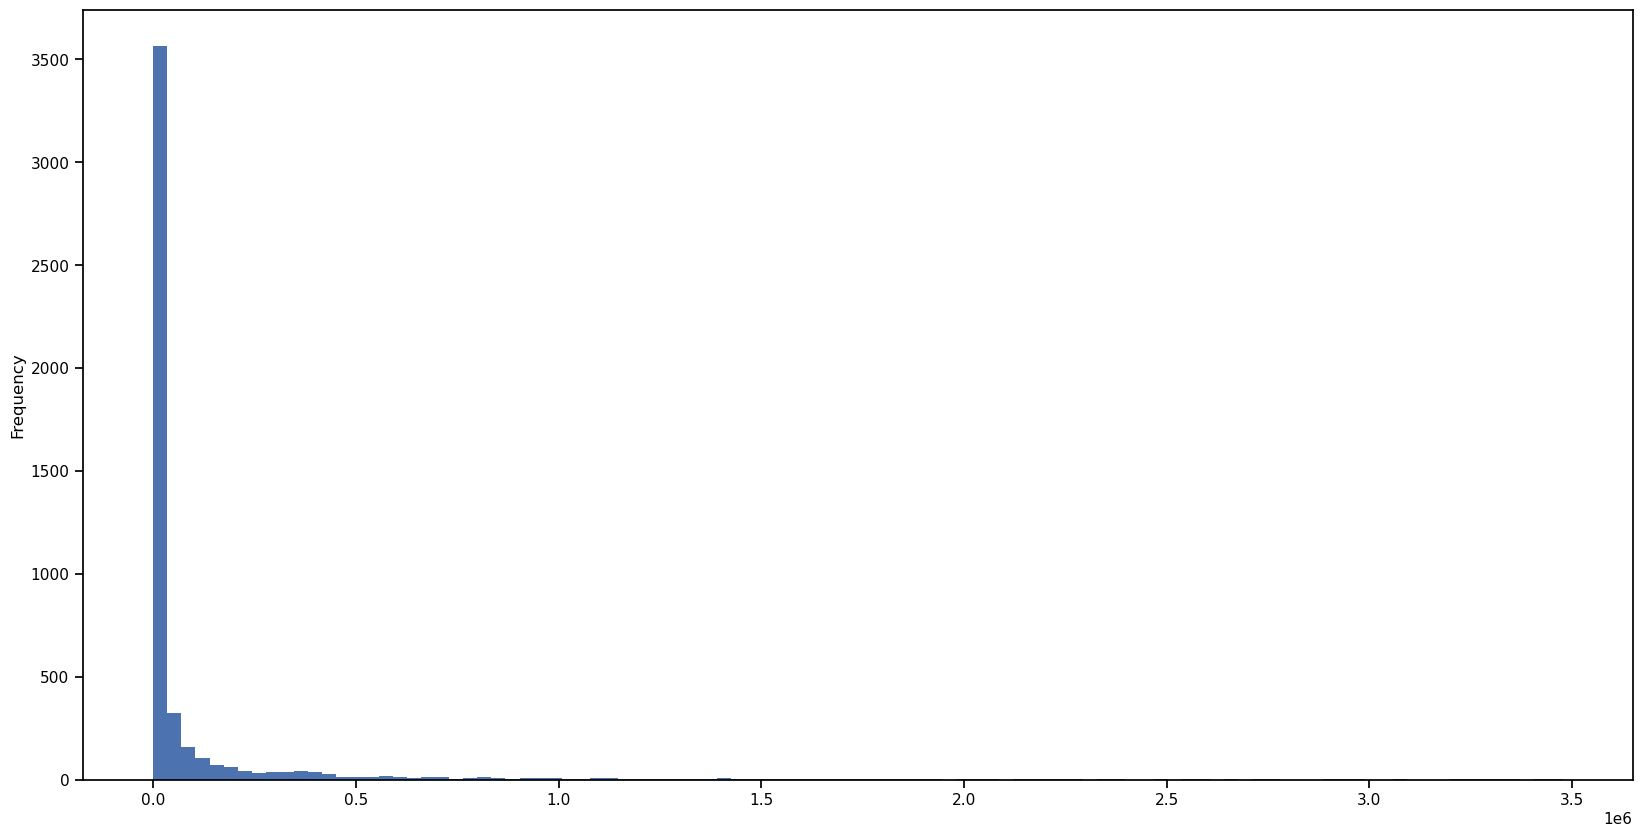

In [36]:
print(fdf['total_func_call'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# fdf[fdf['total_func_call'] < 100].total_func_call.value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
fdf[fdf.total_func_call < fdf.total_func_call.quantile(0.99)].total_func_call.plot(kind='hist', bins=100, figsize=(20, 10))
plt.show()

# shader!

In [37]:
vert_shader_list = []
frag_shader_list = []
fdf_columns = set()
for i, x in enumerate(context_infos):
    vert, frag = extract_shaders(x, i)
    vert_shader_list.extend(vert)
    frag_shader_list.extend(frag)
vert_df = pd.DataFrame(vert_shader_list, columns=['source', 'original', 'url', 'context_id'])
frag_df = pd.DataFrame(frag_shader_list, columns=['source', 'original', 'url', 'context_id'])
vert_df['type'] = 'vert'
frag_df['type'] = 'frag'
shader_df = pd.concat([vert_df, frag_df])
shader_df['source_length'] = shader_df.source.apply(len)
shader_df

,source,original,url,context_id,type,source_length
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136
...,...,...,...,...,...,...
21423,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3276,frag,39
21424,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3277,frag,39
21425,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3278,frag,39
21426,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3279,frag,39


In [38]:
tmp = OUT_PATH / 'example' / 'sampled_shaders'
for context_id, row in shader_df.sample(10).iterrows():
    shader = row.original
    typ = row.type
    with open(tmp / f'{context_id}.{typ}', 'w') as f:
        f.write(shader)

## Diversity of shaders

In [39]:
# group by source and count the different urls
tmp = shader_df.groupby('source').url.count()
shader_df['duplicate_ratio'] = shader_df.source.apply(lambda x: tmp[x])

shader_df

,source,original,url,context_id,type,source_length,duplicate_ratio
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123,1
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542,1
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635,27
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556,1
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136,1
...,...,...,...,...,...,...,...
21423,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3276,frag,39,28
21424,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3277,frag,39,28
21425,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3278,frag,39,28
21426,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3279,frag,39,28


In [40]:
# group by source and count the different urls
tmp = shader_df['duplicate_ratio']
# bar without x axis name
print(tmp.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# lst = tmp.sort_values(ascending=False).to_list()
# fig, axes = plt.subplots(figsize=(20, 10))
# axes.plot(lst)
# axes.set_xlabel('Shader')
# axes.set_ylabel('Number of URLs')
# plt.show()
# tmp.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20, 10))

count    42856.000000
mean       172.036121
std        474.371063
min          1.000000
50%          4.000000
75%         48.000000
90%        424.000000
95%       1746.000000
99%       1746.000000
max       1746.000000
Name: duplicate_ratio, dtype: float64


### Context Level

<Axes: title={'center': 'By context'}, xlabel='Shader ID', ylabel='Number of Contexts'>

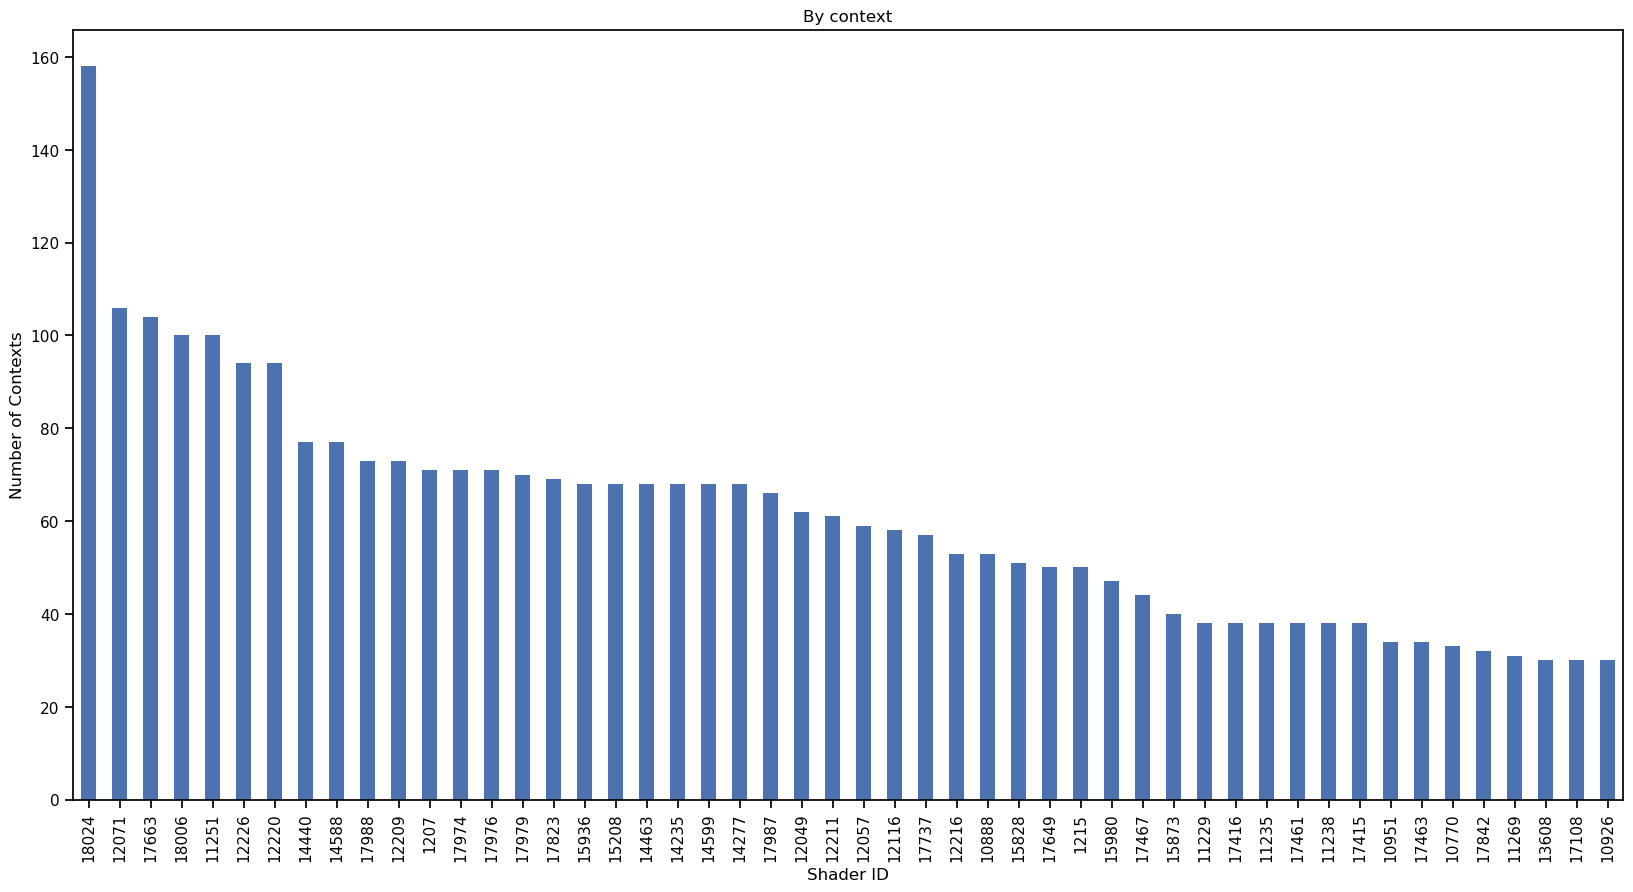

In [41]:
# group by source and count the different urls
tmp = shader_df.groupby('source').context_id.nunique()
# get shader length
tmp_df = pd.DataFrame(tmp).reset_index()
tmp_df['length'] = tmp_df.source.apply(len)
tmp_df.columns = ['source', 'context_count', 'length']
plt.title("By context")
plt.xlabel('Shader ID')
plt.ylabel('Number of Contexts')
tmp_df.sort_values('context_count', ascending=False).head(50).context_count.plot(kind='bar', figsize=(20, 10))


In [42]:
# group by source and count the different urls
tmp = shader_df.groupby('source').url.nunique()
# get shader length
tmp_df = pd.DataFrame(tmp).reset_index()
tmp_df['length'] = tmp_df.source.apply(len)
tmp_df.columns = ['source', 'url_count', 'length']
tmp_df


,source,url_count,length
0,#defineA3.141592653589793precisionhighpfloat;u...,1,1395
1,#defineA3.141592653589793uniformmat4projection...,1,528
2,#defineALPHA_TEST0.001#defineGLSLIFY1attribute...,1,745
3,#defineALPHA_TEST0.001#ifdefGL_OES_standard_de...,1,1560
4,#defineALPHA_TEST0.5#defineMAX_BONES65#defineU...,1,598
...,...,...,...
18084,varyingvec2vUv;uniformmat4modelViewMatrix;unif...,2,2034
18085,varyingvec3vNormal;attributevec2uv;attributeve...,1,482
18086,"voidmain(){gl_FragColor=vec4(1,0,0,1);}",9,39
18087,"voidmain(){if(length(gl_PointCoord-vec2(0.5,0....",1,99


In [43]:
# merge shader_df.type on source
tmp_df = tmp_df.merge(shader_df[['source', 'type']], on='source', how='left')
tmp_df = tmp_df.drop_duplicates(subset=['source'])
tmp_df

,source,url_count,length,type
0,#defineA3.141592653589793precisionhighpfloat;u...,1,1395,frag
1,#defineA3.141592653589793uniformmat4projection...,1,528,vert
2,#defineALPHA_TEST0.001#defineGLSLIFY1attribute...,1,745,vert
4,#defineALPHA_TEST0.001#ifdefGL_OES_standard_de...,1,1560,frag
6,#defineALPHA_TEST0.5#defineMAX_BONES65#defineU...,1,598,vert
...,...,...,...,...
42823,varyingvec2vUv;uniformmat4modelViewMatrix;unif...,2,2034,vert
42825,varyingvec3vNormal;attributevec2uv;attributeve...,1,482,vert
42826,"voidmain(){gl_FragColor=vec4(1,0,0,1);}",9,39,frag
42854,"voidmain(){if(length(gl_PointCoord-vec2(0.5,0....",1,99,frag


In [44]:
# bar without x axis name
print(tmp_df.url_count.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
tmp = tmp_df.sort_values(by='url_count', ascending=False).head(50)
tmp

count    18089.000000
mean         1.347504
std          2.649067
min          1.000000
50%          1.000000
75%          1.000000
90%          1.000000
95%          2.000000
99%          8.000000
max        105.000000
Name: url_count, dtype: float64


,source,url_count,length,type
42470,precisionmediumpfloat;varyingvec4vColor;voidma...,105,76,frag
42248,precisionmediumpfloat;varyingvec2varyinTexCoor...,73,108,frag
21007,attributevec2attrVertex;varyingvec2varyinTexCo...,73,170,vert
24141,precisionhighpfloat;attributevec2aVertexPositi...,69,342,vert
24460,precisionhighpfloat;attributevec2aVertexPositi...,69,323,vert
3561,#definen20precisionmediumpfloat;precisionmediu...,65,756,vert
41142,precisionmediumpfloat;precisionmediumpint;attr...,63,746,vert
23144,precisionhighpfloat;#defineSHADER_NAMEpixi-sha...,58,488,vert
22980,precisionhighpfloat;#defineSHADER_NAMEpixi-sha...,58,373,vert
40466,precisionmediumpfloat;#defineSHADER_NAMEpixi-s...,57,1278,frag


In [45]:
tmp['index'] = tmp.index

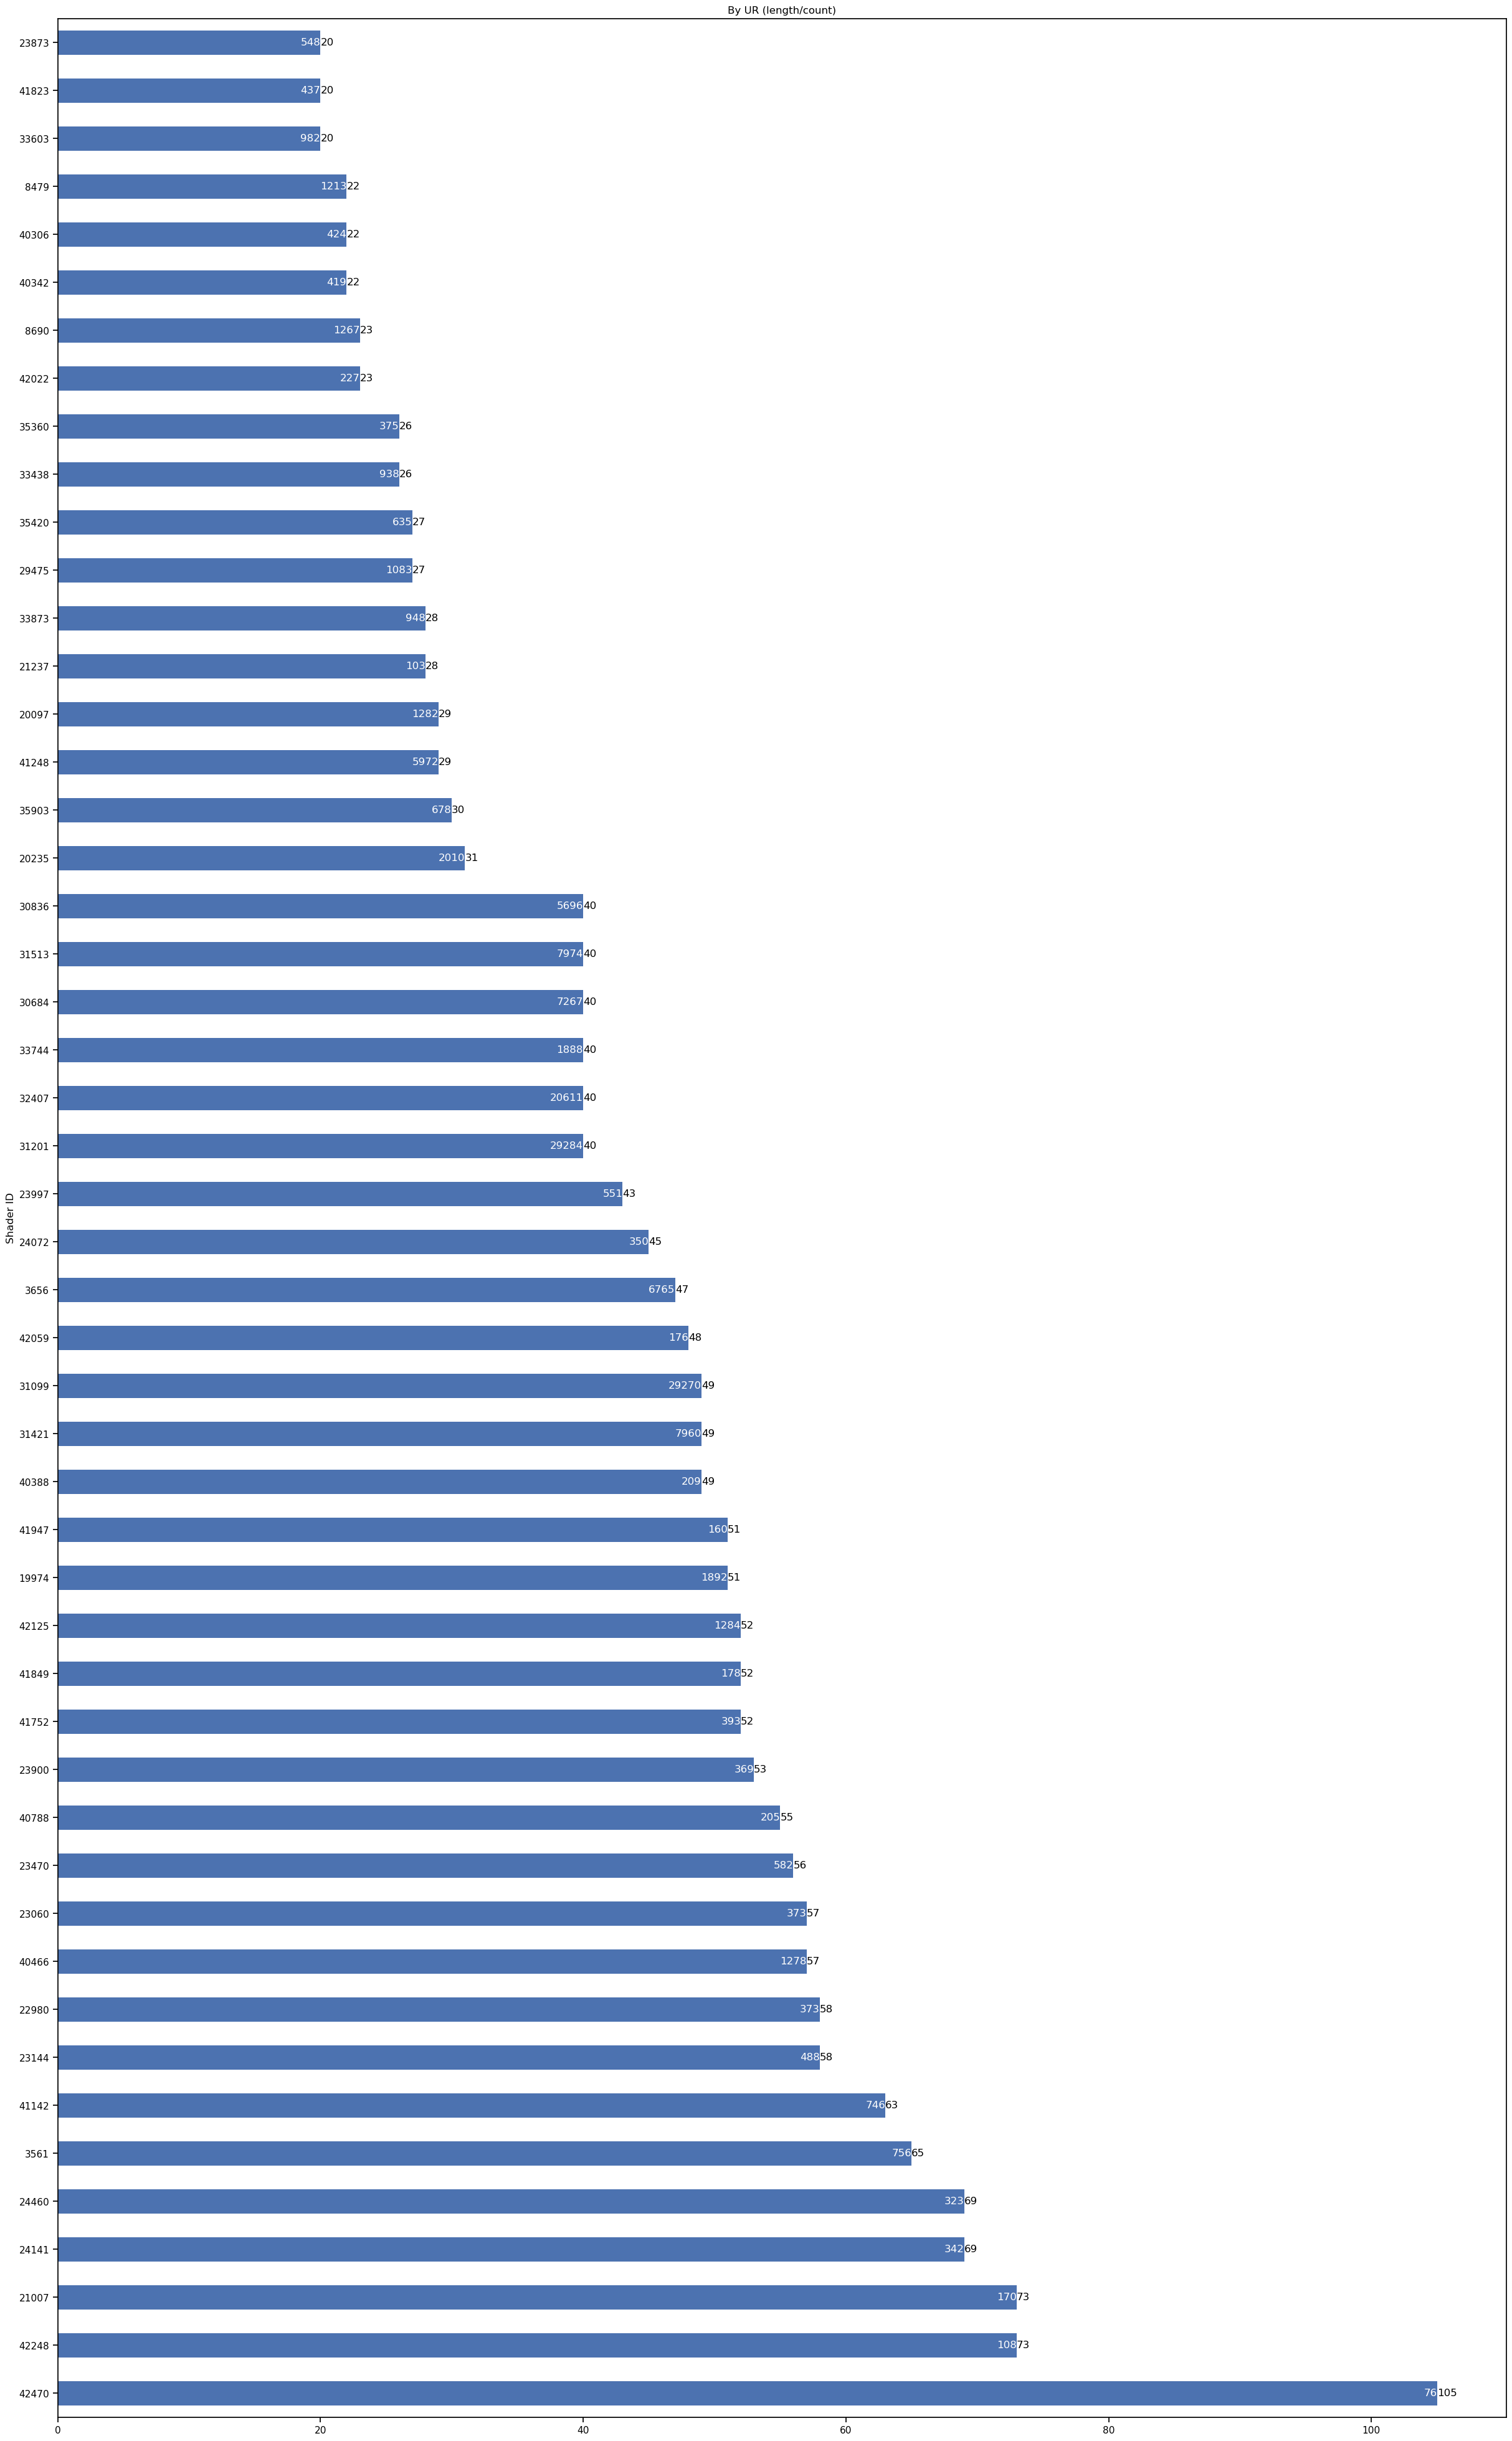

In [46]:
# plt.figure(figsize=(30, 50))
plt.title("By UR (length/count)")
plt.xlabel('Number of URLs')
plt.ylabel('Shader ID')
bar = tmp.url_count.plot(kind='barh', figsize=(30, 50))
# bar = sns.barplot(x='url_count', y='index', hue='type', data=tmp, orient='h')
# label length on top of bar
for rect, url_count, length in zip(bar.patches,tmp.url_count,tmp.length):
    bar.annotate(f'{url_count}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='left', va='center')
    bar.annotate(f'{length}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='right', va='center', color='white')
    
plt.show()

In [47]:
# shader_df = shader_df[shader_df.url != 'https://admireamaze.debijenkorf.nl/']

Percentage of all unique shaders: 42.21%


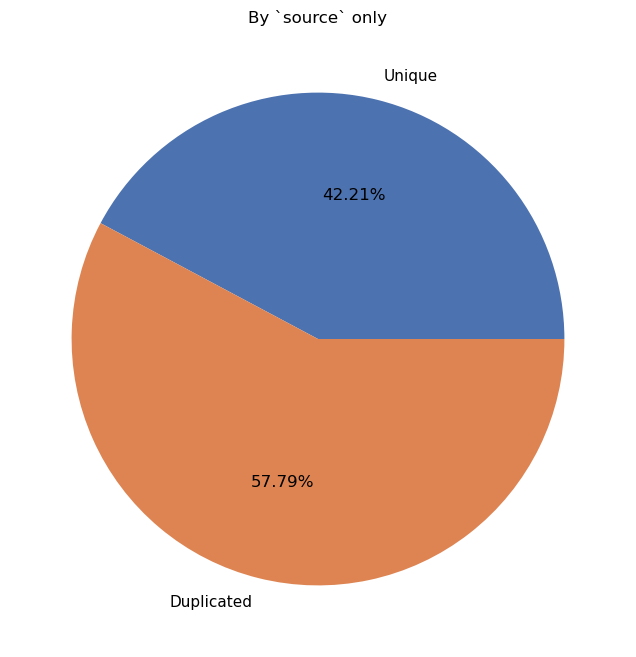

In [48]:
shader_df_dedup = shader_df.drop_duplicates(subset=['source'], keep='first')
tmp = len(shader_df_dedup) / len(shader_df) * 100
print("Percentage of all unique shaders: {:.2f}%".format(len(shader_df_dedup) / len(shader_df) * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By `source` only')
plt.show()

In [49]:
# list some duplicated shaders
tmp = shader_df[shader_df.source.duplicated(keep='first')]
print(len(tmp.url.unique()))
print(len(shader_df.url.unique()))
print(len(shader_df_dedup.url.unique()))

1539
2020
1689


In [50]:
tmp = shader_df.drop_duplicates(subset=['context_id', 'source'], keep='first')
tmp

,source,original,url,context_id,type,source_length,duplicate_ratio
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123,1
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542,1
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635,27
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556,1
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136,1
...,...,...,...,...,...,...,...
21423,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3276,frag,39,28
21424,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3277,frag,39,28
21425,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3278,frag,39,28
21426,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3279,frag,39,28


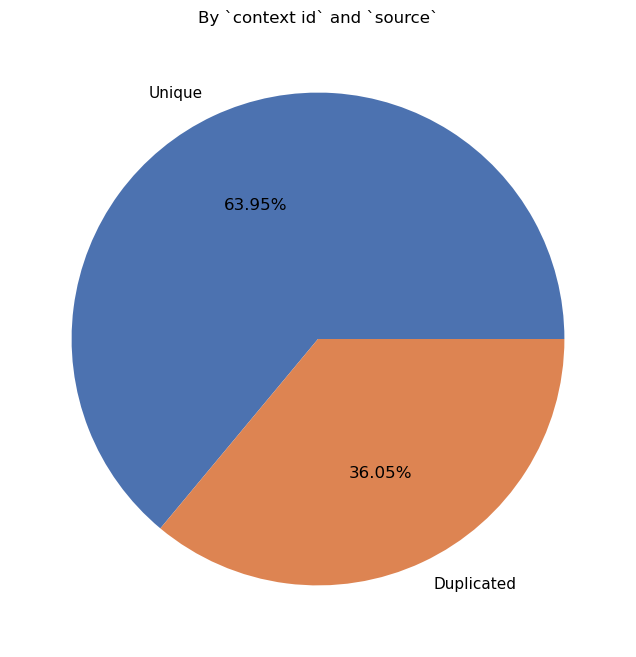

In [51]:
tmp = len(tmp) / len(shader_df) * 100
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title("By `context id` and `source`")
plt.show()

In [52]:
tmp = shader_df.drop_duplicates(subset=['source', 'url'], keep='first')
tmp

,source,original,url,context_id,type,source_length,duplicate_ratio
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123,1
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542,1
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635,27
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556,1
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136,1
...,...,...,...,...,...,...,...
21413,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/lyudi,3266,frag,39,28
21415,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/lyudi/lnt-v-kalifornii-vyst...,3268,frag,39,28
21417,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/news,3270,frag,39,28
21419,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/svetskaya-khronika/kak-pros...,3272,frag,39,28


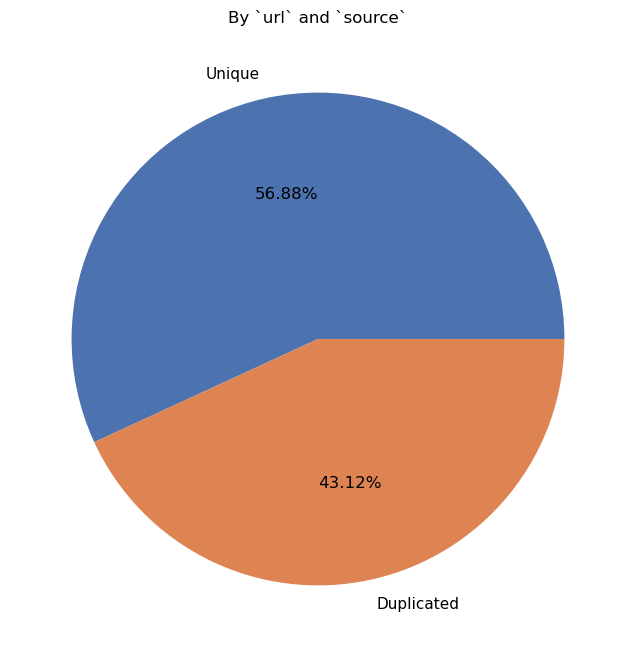

In [53]:
tmp = len(tmp) / len(shader_df) * 100
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title("By `url` and `source`")
plt.show()

## Shader Count

==0 count     2040.000000
mean       174.006373
std       1613.176370
min          1.000000
25%          2.000000
50%          5.000000
75%          8.000000
max      52511.000000
Name: total_func_call, dtype: float64
count    4875.000000
mean        8.790974
std        68.879487
min         0.000000
25%         0.000000
50%         2.000000
75%         8.000000
90%        18.000000
95%        34.000000
99%        90.000000
max      4482.000000
Name: shader_count, dtype: float64


,url,shader_count,program_count,_resources_shader,_resources_program
523,https://admireamaze.debijenkorf.nl/,4482,2242,4,2235


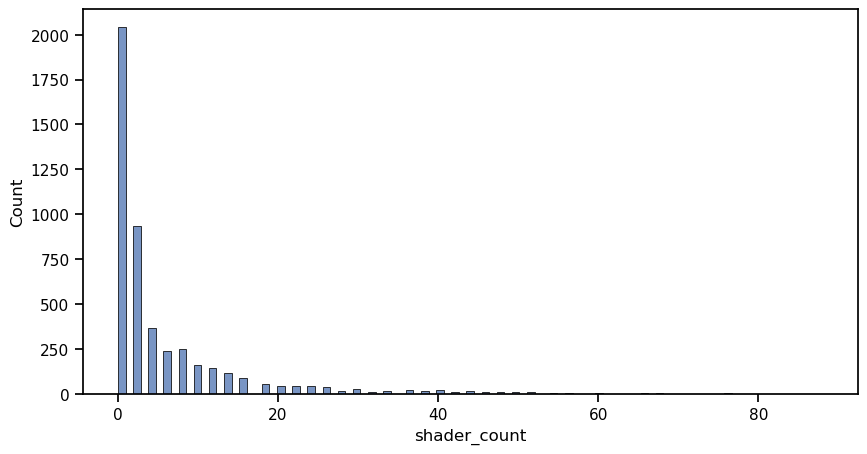

In [54]:
print('==0', fdf[fdf['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['shader_count'] < tmp['99%']], x="shader_count", multiple="stack")
plt.plot()
fdf[fdf['shader_count'] > 4000][['url', 'shader_count', 'program_count', '_resources_shader', '_resources_program']]


In [55]:
tmp = fdf_url.loc[fdf_url['shader_count']==0].copy()

In [56]:
# remove columns that sum=0
for x in tmp.columns:
    if tmp[x].sum() == 0:
        tmp.drop(x, axis=1, inplace=True)

In [57]:
tmp.to_excel(OUT_PATH / 'example' / 'shader_count_is_0.xlsx')

==0 count      625.000000
mean       368.526400
std       2702.041869
min          1.000000
25%          3.000000
50%          8.000000
75%         42.000000
max      52513.000000
Name: total_func_call, dtype: float64
count    2645.000000
mean       16.202647
std        93.521239
min         0.000000
25%         2.000000
50%         6.000000
75%        16.000000
90%        36.000000
95%        50.000000
99%       136.000000
max      4482.000000
Name: shader_count, dtype: float64


,shader_count,program_count,_resources_shader,_resources_program
url,,,,
https://admireamaze.debijenkorf.nl/,4482,2244,4,2235


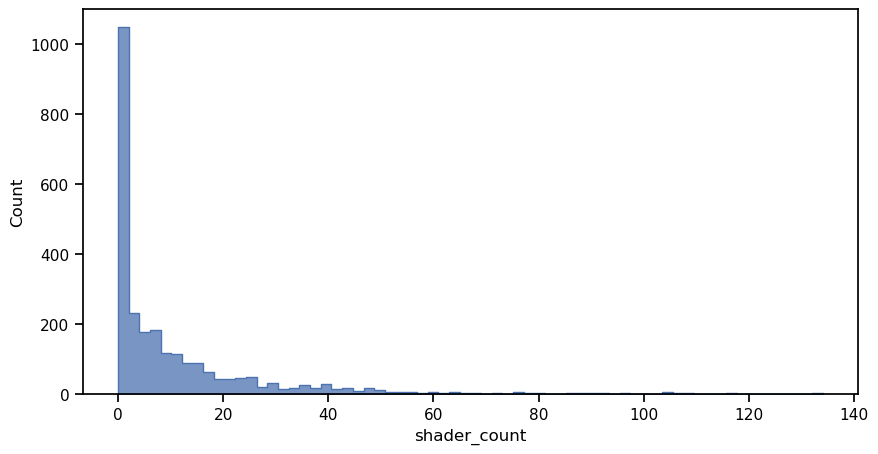

In [58]:
print('==0', fdf_url[fdf_url['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf_url['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf_url[fdf_url['shader_count'] < tmp['99%']], x="shader_count", element='step')
plt.plot()
fdf_url[fdf_url['shader_count'] > 4000][['shader_count', 'program_count', '_resources_shader', '_resources_program']]

## shader length

In [59]:
print(shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count     42856.000000
mean       5499.212129
std       10455.717834
min          39.000000
25%         375.000000
50%        1282.000000
75%        6258.000000
90%       11192.000000
95%       31773.500000
99%       48674.850000
max      109735.000000
Name: source_length, dtype: float64


[]

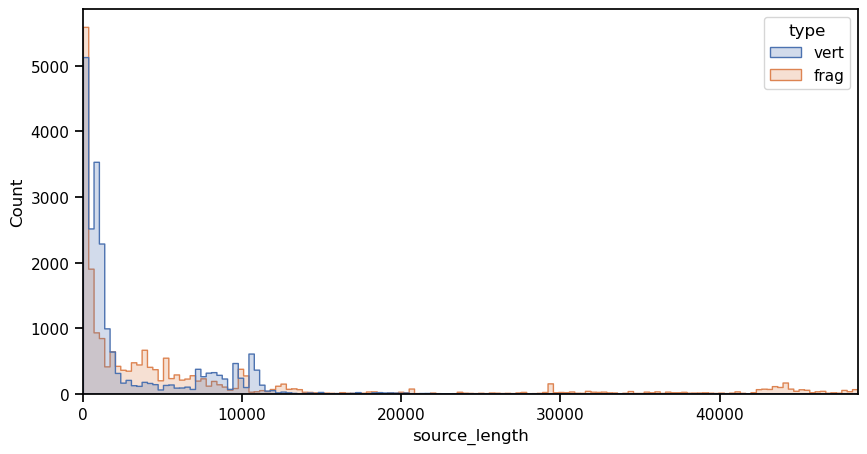

In [60]:
tmp = shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
sns.histplot(data=shader_df, x="source_length", hue="type", multiple="layer", element="step")
plt.plot()

In [61]:
# vert, frag shaderlength median/ mean
shader_df_vert = shader_df[shader_df.type == 'vert']
shader_df_frag = shader_df[shader_df.type == 'frag']

print('vert', shader_df_vert.describe())
print('frag', shader_df_frag.describe())

vert          context_id  source_length  duplicate_ratio
count  21428.000000   21428.000000     21428.000000
mean     893.148497    2889.702259       175.681632
std      755.074228    3885.500601       473.531534
min        0.000000      41.000000         1.000000
25%      333.000000     393.000000         2.000000
50%      558.000000     973.500000         7.000000
75%     1354.000000    3865.000000        59.000000
max     3309.000000   27845.000000      1746.000000
frag          context_id  source_length  duplicate_ratio
count  21428.000000   21428.000000     21428.000000
mean     893.148497    8108.721999       168.390610
std      755.074228   13781.594206       475.192191
min        0.000000      39.000000         1.000000
25%      333.000000     330.000000         1.000000
50%      558.000000    2375.000000         3.000000
75%     1354.000000    7581.000000        33.000000
max     3309.000000  109735.000000      1746.000000


# Programs

count    4875.000000
mean        5.315282
std        34.405909
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
90%        10.000000
95%        17.300000
99%        44.000000
max      2242.000000
Name: program_count, dtype: float64


[]

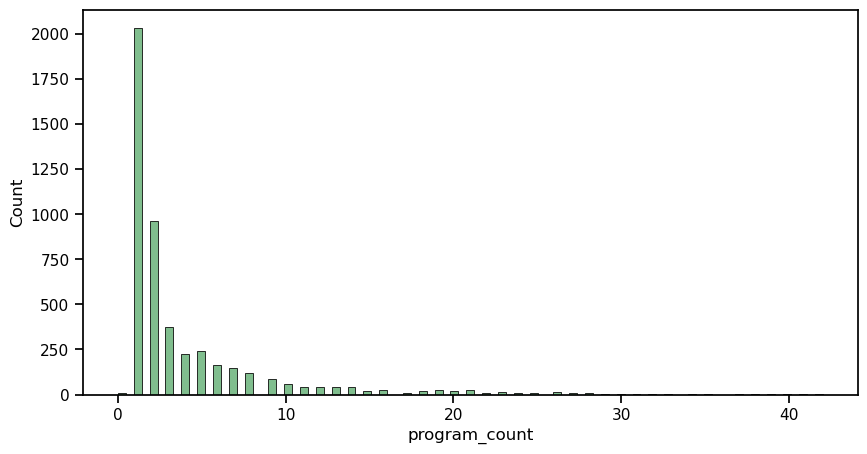

In [62]:
tmp = fdf['program_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['program_count'] < tmp['99%']], x="program_count", multiple="stack", color=sns.color_palette()[2])
plt.plot()

# Textures

count    4875.000000
mean       10.003692
std        52.122862
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
90%        20.000000
95%        38.300000
99%       137.260000
max      2314.000000
Name: _resources_texture, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
523,https://admireamaze.debijenkorf.nl/,32626.4,1679343872683,2432.9,6425.8,2164.6,webgl2,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


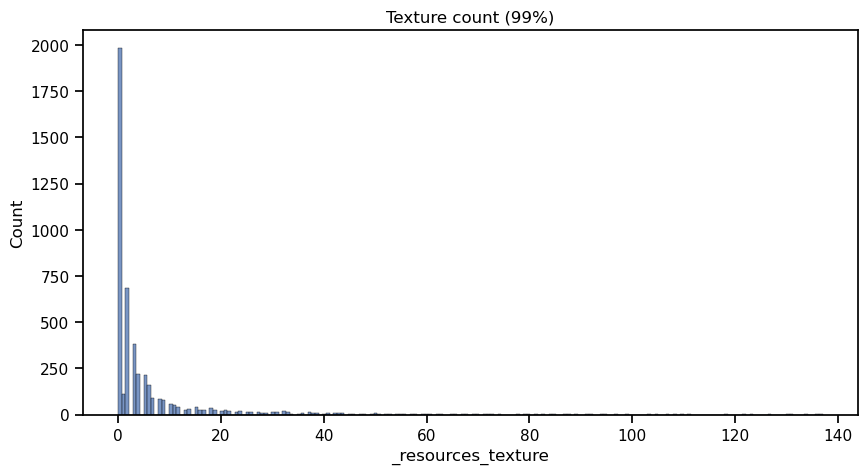

In [63]:
# plot shader_count
tmp = fdf['_resources_texture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('Texture count (99%)')
sns.histplot(data=fdf[fdf['_resources_texture'] < tmp['99%']], x="_resources_texture", multiple="stack")
plt.plot()
fdf[fdf['_resources_texture'] > 2000]

count    4875.000000
mean       10.604513
std        53.013910
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
90%        21.000000
95%        42.000000
99%       156.000000
max      2314.000000
Name: _func_call_createTexture, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
523,https://admireamaze.debijenkorf.nl/,32626.4,1679343872683,2432.9,6425.8,2164.6,webgl2,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


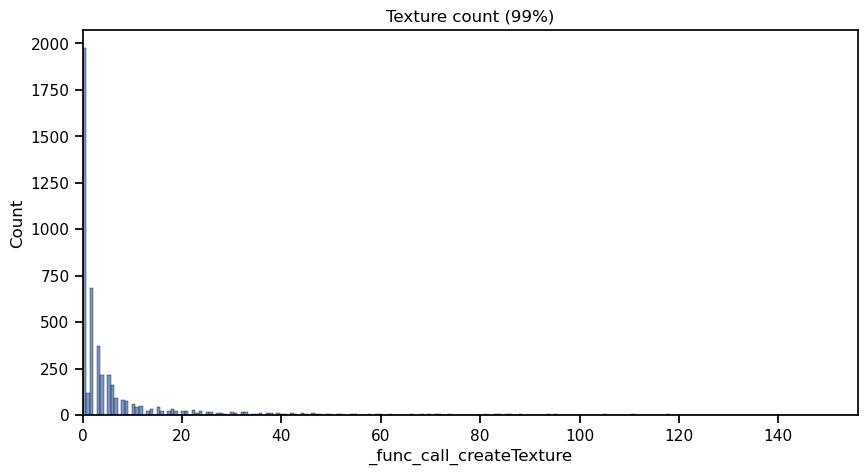

In [64]:
# plot shader_count
tmp = fdf['_func_call_createTexture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
plt.title('Texture count (99%)')
sns.histplot(data=fdf, x="_func_call_createTexture", multiple="stack")
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createTexture'] > 2000]

# VAO

count     4875.000000
mean        21.297231
std        433.171224
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          8.000000
95%         35.000000
99%        225.300000
max      26001.000000
Name: _func_call_createVertexArray, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
2,http://127.0.0.1:8000/test3/webgl/medium,31640.2,1679326403021,1228.5,1228.7,1024.6,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
18,https://hydrogen.shopify.dev/,32187.5,1679359998547,1274.9,3064.4,1820.5,webgl2,True,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
24,https://universo.creatividadargentina.org/,37136.8,1679385108373,6609.8,10403.9,6705.1,webgl2,True,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
391,http://127.0.0.1:8000/test3/webgl/hard,31591.8,1679326369604,2276.0,2276.1,1581.2,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
527,https://warszawskiul.com/en/,38258.9,1679388070574,7859.0,7864.4,7902.9,webgl2,True,False,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


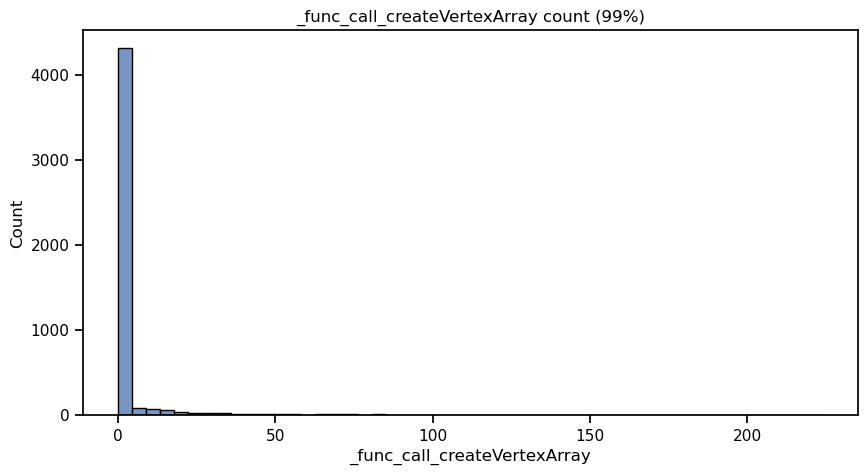

In [65]:
# plot shader_count
tmp = fdf['_func_call_createVertexArray'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('_func_call_createVertexArray count (99%)')
sns.histplot(data=fdf[fdf['_func_call_createVertexArray'] < tmp['99%']], x="_func_call_createVertexArray", multiple="stack", bins=50)
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createVertexArray'] > 2000]

# Memory Total (roughly)

count    4.875000e+03
mean     6.377012e+07
std      1.182073e+08
min      0.000000e+00
25%      1.080000e+06
50%      1.936834e+07
75%      8.410397e+07
90%      1.651745e+08
95%      2.599279e+08
99%      5.781983e+08
max      1.792194e+09
Name: _memory_total, dtype: float64


[]

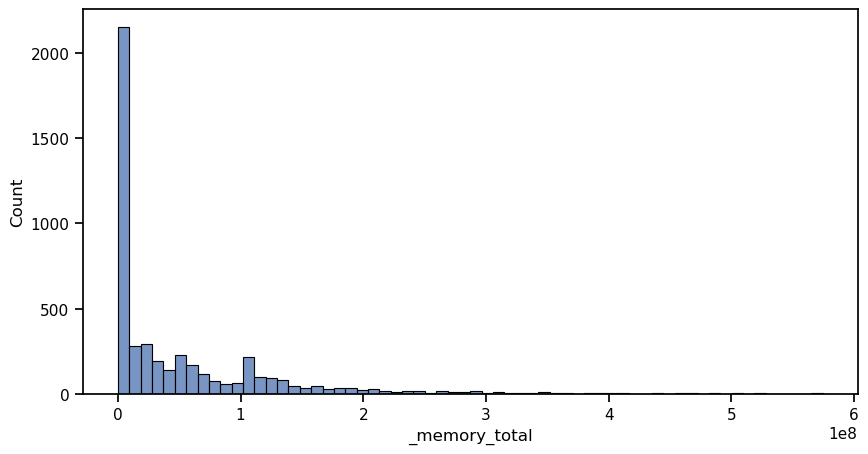

In [66]:
tmp = fdf['_memory_total'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['_memory_total'] < tmp['99%']], x="_memory_total", multiple="stack")
plt.plot()

# Vertex & Triangle

In [67]:
fdf['vertexCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    4.875000e+03
mean     8.830529e+07
std      6.339676e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.200000e+01
75%      2.760165e+06
90%      1.084928e+08
95%      3.359102e+08
99%      1.727973e+09
max      2.579857e+10
Name: vertexCount, dtype: float64

In [68]:
fdf[fdf['vertexCount'] == 0][['url', '_func_call_drawElements', '_func_call_drawArrays', '_func_call_drawBuffers', '_func_call_drawElementsInstanced', '_func_call_drawArraysInstanced']]

,url,_func_call_drawElements,_func_call_drawArrays,_func_call_drawBuffers,_func_call_drawElementsInstanced,_func_call_drawArraysInstanced
116,https://yar-studio.com/,249331.0,29860.0,2986.0,4479.0,0.0
117,https://jet.style/portfolio/case/promo-page-of...,0.0,0.0,0.0,78772.0,0.0
391,http://127.0.0.1:8000/test3/webgl/hard,0.0,0.0,1.0,0.0,0.0
478,https://artsexperiments.withgoogle.com/diving-...,0.0,4200.0,0.0,0.0,0.0
608,https://rapport-annuel.epfl.ch/en/2021/,0.0,0.0,0.0,14472.0,0.0
...,...,...,...,...,...,...
4870,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
4871,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
4872,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
4873,https://www.thoughtlab.com/,0.0,0.0,0.0,0.0,0.0


In [69]:
fdf['triangleCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    4.875000e+03
mean     2.666903e+07
std      2.064127e+08
min     -1.640000e+02
25%      0.000000e+00
50%      1.000000e+00
75%      2.718740e+05
90%      2.831484e+07
95%      9.715166e+07
99%      5.371987e+08
max      8.598965e+09
Name: triangleCount, dtype: float64

# RequestAnimationFrame(RAF)

count    4.875000e+03
mean     1.077510e+04
std      1.350069e+05
min      0.000000e+00
25%      3.450000e+02
50%      2.124000e+03
75%      5.398000e+03
90%      9.640200e+03
95%      1.486500e+04
99%      3.240500e+04
max      3.999917e+06
Name: rafCalled_total, dtype: float64


[]

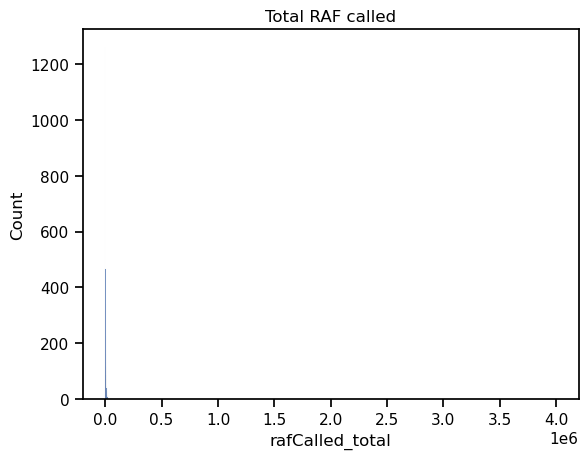

In [70]:
print(fdf.rafCalled_total.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_total", multiple="stack")
plt.title('Total RAF called')
plt.plot()

count    4.875000e+03
mean     8.071085e+03
std      1.343101e+05
min      0.000000e+00
25%      5.700000e+01
50%      9.670000e+02
75%      2.038000e+03
90%      4.954400e+03
95%      5.442000e+03
99%      1.010400e+04
max      3.998313e+06
Name: rafCalled_max, dtype: float64


[]

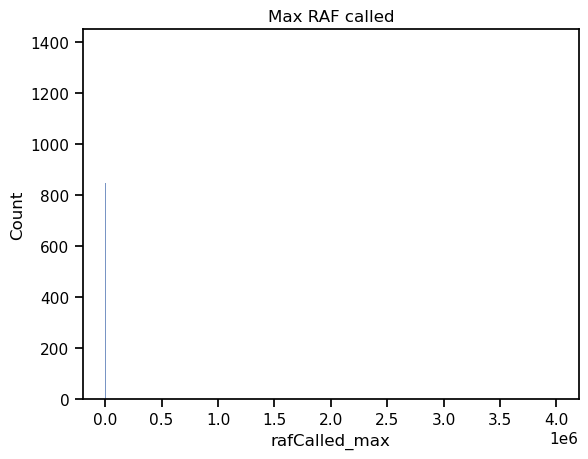

In [71]:
print(fdf.rafCalled_max.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_max", multiple="stack")
plt.title('Max RAF called')
plt.plot()